# Introduction to PyTorch

In this assignment, we will use PyTorch, one of the most popular deep learning libraries out there. Similarly to programming languages, deep learning libraries can be very different in terms of syntax, yet they all revolve around the same concepts, so once you master one, learning another is much less challenging. We also use `torchvision` to load data, and `torcheval` to provide an implementation of the evaluation functions. The code below, once uncommented, may install the necessary dependencies, but it may not - it depends on your system. Please be advised that PyTorch is a rather large library (the WHL file is almost 200MB).

In [19]:
#!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

In [20]:
#!pip install torcheval

## The MNIST Dataset

We begin by loading the MNIST dataset into the memory. If it is not available in the directory `datasets`, it will be downloaded from the Internet. But to load the dataset, we must first make some preparations. First, we import the MNIST class, which is the appropriate data loader.

In [21]:
from torchvision.datasets import MNIST

We now prepare a transformation pipeline. Each image is loaded as an object of the class `PIL.Image`, which is not entierly convenient for us. Instead, we will convert them into PyTorch tensors (objects very similar to numpy's arrays, i.e., matrices of an arbitrary number of dimensions), and then scale them into the range 0-1 (originally, each pixel is represented as a 0-255 integer). Finally, we normalize them, so their mean is equal to 0, and their standard deviation is equal to 1 (the magic constants in the code correspond to the mean and standard deviation of the training set of MNIST)

In [22]:
from torchvision.transforms import v2
import torch

transform = v2.Compose([
    v2.PILToTensor(), 
    v2.ToDtype(torch.float32, scale=True), 
    v2.Normalize([0.1307], [0.3081])
])

We are finally redy to load the data.

In [23]:
training = MNIST(root="datasets", train=True, download=True, transform=transform)
test = MNIST(root="datasets", train=False, download=True, transform=transform)

The data is presplit, and as the name suggest `training` is the subset for training, while `test` is the subset for the final testing. Let's inspect it.

In [24]:
print("Training X shape", training.data.shape)
print("Training y shape", training.targets.shape)
print("Test X shape", test.data.shape)
print("Test y shape", test.targets.shape)

Training X shape torch.Size([60000, 28, 28])
Training y shape torch.Size([60000])
Test X shape torch.Size([10000, 28, 28])
Test y shape torch.Size([10000])


We read the following:

* There are 60,000 training images
* There are 10,000 test images
* Each image is 28x28

It is interesting to display a few. We will use the PIL library and the Jupyter Widgets. Both should be already installed, but if they are not - don't sweat, this is not a necessary part to complete the notebook.

In [25]:
from IPython.display import display
from PIL import Image

display(Image.fromarray(training.data[0].numpy()), 
        Image.fromarray(training.data[1000].numpy()), 
        Image.fromarray(training.data[25000].numpy()), 
        Image.fromarray(training.data[52000].numpy()))
print(training.targets[0].item(), training.targets[1000].item(), training.targets[25000].item(), training.targets[52000].item())

5 0 3 6


If everything went well, you should now see 4 black and white images of digits corresponding to the numbers printed out to the bottom of the output of the last cell.

Since we will be working in mini-batches, it is convenient to offload the work of shuffling and splitting the data. The following cell creates a data loader that, upon iteration, will yield mini-batches of 128 paris of learning examples.

In [26]:
from torch.utils.data import DataLoader

training_loader = DataLoader(training, batch_size=128, shuffle=True)

However, for such small test data, it is more convenient to use them all at once. The following cell creates tensors `X_test`, `y_test` which are, respectively, the entire 10,000 images from the test set, and their corresponding labels.

In [27]:
test_loader = DataLoader(test, batch_size=len(test), shuffle=False)
X_test, y_test = next(iter(test_loader))

## Building and training a simple model

We will now create a very simple neural network and train it to recognize the digit in the image -- that is, to classify an image into one of the 10 classes: 0, 1, ..., 9.

The model consists of the following layers:

 1. A flattening layer (`nn.Flatten`) casting a 2D matrix as a 1D vector.
 2. A linear layer (`nn.Linear`) having `28*28` inputs and `300` outputs
  3. The ReLU activation function (`nn.ReLU`)
  4. A linear layer (`nn.Linear`) having `10` outputs
     
To combine layers into a single model use `nn.Sequential`.
Ordinarily, we'd include the softmax activation at the end. However, since it is integrated into the loss function that we will use, it is not necessary.

In [28]:
import torch.nn as nn

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 300),
    nn.ReLU(),
    nn.Linear(300, 10)
)

We can simply print the model to see its architecture

In [29]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=300, bias=True)
  (2): ReLU()
  (3): Linear(in_features=300, out_features=10, bias=True)
)

We must decide on the loss function. Since we are dealing with a multiclass problem, we will use the cross entropy, which is an extension of the binary cross entropy (see the lecture on machine learning) to multi-class problems.

In [30]:
loss = nn.CrossEntropyLoss()

We also need to decide on an optimization algorithm. We will use `Adam`, which is a convenient extension of the gradient descent algorithm that works well in a wide variety of cases without further tuning. Since it needs to know what is to be optimized, it receives the model's parameters in the constructor.

In [31]:
import torch.optim

optimizer = torch.optim.Adam(model.parameters())

Finally, we are ready to perform the actual training. We implement mini-batch learning over 20 epochs. Within each epoch:
1. We set the model to the training mode.
1. We go over all mini-batches in the training data:
    1. We zero the gradients stored by the optimizer (`opt.zero_grad()`)
    2. We perform the forward pass and compute the outputs of the model (`model(X_batch)`)
    3. We compute the value of the loss function.
    4. We compute the gradients (`loss_value.backward()`) and apply them (`optimizer.step()`) to update the parameters of the model
2. We switch the model to the evaluation mode.
3. We compute the forward pass of the model
4. We compute the accuracy of the model 

After an epoch is completed, we average the collected MSEs and store the value.

In [32]:
from torcheval.metrics.functional import multiclass_accuracy

for epoch in range(20):    
    model.train()
    for X_batch, y_batch in training_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss_value = loss(y_pred, y_batch)
        loss_value.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

    acc = multiclass_accuracy(y_pred, y_test)    
    print("Epoch", epoch, "accuracy", acc.item())

Epoch 0 accuracy 0.9621000289916992
Epoch 1 accuracy 0.9710000157356262
Epoch 2 accuracy 0.9743000268936157
Epoch 3 accuracy 0.9718999862670898
Epoch 4 accuracy 0.9757999777793884
Epoch 5 accuracy 0.9761999845504761
Epoch 6 accuracy 0.9796000123023987
Epoch 7 accuracy 0.9797999858856201
Epoch 8 accuracy 0.980400025844574
Epoch 9 accuracy 0.9750000238418579
Epoch 10 accuracy 0.9801999926567078
Epoch 11 accuracy 0.9793000221252441
Epoch 12 accuracy 0.9796000123023987
Epoch 13 accuracy 0.9779999852180481
Epoch 14 accuracy 0.9801999926567078
Epoch 15 accuracy 0.9822999835014343
Epoch 16 accuracy 0.9794999957084656
Epoch 17 accuracy 0.980400025844574
Epoch 18 accuracy 0.980400025844574
Epoch 19 accuracy 0.9807999730110168


Execute the preceeding cell of the code again. Because the model and the optimizer were not created anew, the parameters are already optimized and the obtained values are vastly different. In order to return to the initial state it is necessary to create new objects `model` and `optimizer`.

## Task 1: LeNet-5

Complete the following function `create_model` implementing a model similar to [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), according to the following description:


|#|Type|Input size|\# of filters|Kernel size|Stride|Padding|Activation function|
|----------|---|---------------|--------------|-----------------------|---------------|-------|-----------------|
|1|convolution|$28\times 28$|6|$5\times 5$|1|2|tanh|
|2|avgerage pooling|$14\times 14$|6|$2\times 2$|2|0|tanh|
|3|convolution|$10\times 10$|16|$5\times 5$|1|0|tanh|
|4|average pooling|$5\times 5$|16|$2\times 2$|2|0|tanh|
|5|convolution|$1\times 1$|120|$5\times 5$|1|0|tanh|
|6|fully connected|84|||||tanh|
|7|fully connected|10|||||none|

You will need to consult the documentation for PyTorch `torch.nn` module.
The next cell of code will materialize the model and train it from scratch. If everything goes well you should get over 99\% accuracy.

In [33]:
def create_model():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0),
        nn.Tanh(),
        nn.Flatten(),
        nn.Linear(120, 84),
        nn.Tanh(),
        nn.Linear(84, 10)
    )

In [34]:
model = create_model()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(200):    
    model.train()
    for X_batch, y_batch in training_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss_value = loss(y_pred, y_batch)
        loss_value.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

    acc = multiclass_accuracy(y_pred, y_test)
    print("Epoch", epoch, "accuracy", acc.item())

    if acc.item() >= .99:
        break

Epoch 0 accuracy 0.96670001745224
Epoch 1 accuracy 0.9803000092506409
Epoch 2 accuracy 0.9836999773979187
Epoch 3 accuracy 0.9865000247955322
Epoch 4 accuracy 0.9868000149726868
Epoch 5 accuracy 0.9873999953269958
Epoch 6 accuracy 0.9853000044822693
Epoch 7 accuracy 0.9836999773979187
Epoch 8 accuracy 0.9871000051498413
Epoch 9 accuracy 0.9890999794006348
Epoch 10 accuracy 0.9886999726295471
Epoch 11 accuracy 0.9879000186920166
Epoch 12 accuracy 0.9896000027656555
Epoch 13 accuracy 0.9886000156402588
Epoch 14 accuracy 0.9889000058174133
Epoch 15 accuracy 0.989799976348877
Epoch 16 accuracy 0.9865000247955322
Epoch 17 accuracy 0.9886999726295471
Epoch 18 accuracy 0.9871000051498413
Epoch 19 accuracy 0.9889000058174133
Epoch 20 accuracy 0.989300012588501
Epoch 21 accuracy 0.9904000163078308


## Task 2: Error analysis

In the following cell, display as images 10 examples from the test set that are classified incorrectly by the trained model from Task 1. Along the images, print out the correct label and the predicted label.

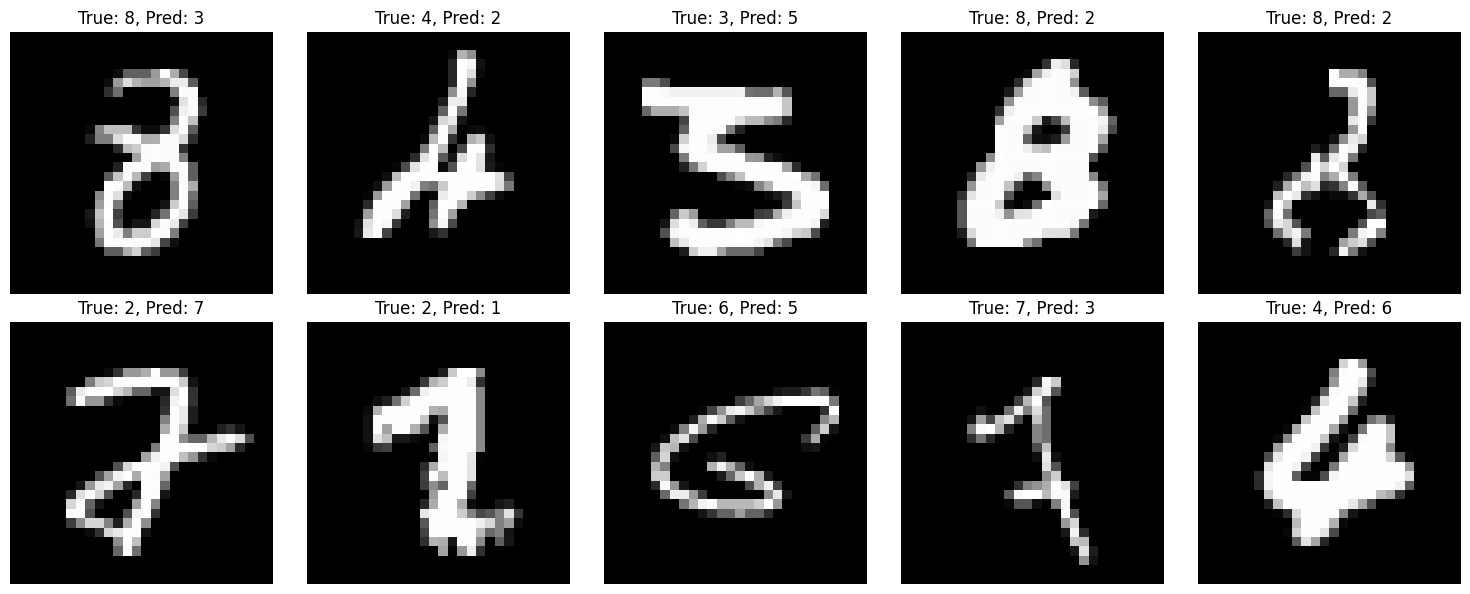

In [35]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test)
    y_pred_labels = torch.argmax(y_pred_logits, dim=1)

errors = (y_pred_labels != y_test).nonzero(as_tuple=True)[0]

plt.figure(figsize=(15, 6))
for i in range(min(10, len(errors))):
    index = errors[i].item()
    img = X_test[index].squeeze().numpy()
    true_label = y_test[index].item()
    pred_label = y_pred_labels[index].item()

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

----
Some final remarks:

* As all deep learning libraries, PyTorch offers support for offloading computation to GPU. In practice the difference can be tremendous, but you need an appropriate graphics card. Since this is a rather restrictive requirement, I elected not to introduce this aspect. If you are interested, see e.g. [https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html). If you don't have the hardware required, there are services out there that will allow you to access one for free for a short time, e.g., Google Colab [https://colab.research.google.com/](https://colab.research.google.com/) or Paperspace Gradient [https://www.paperspace.com/gradient/free-gpu](https://www.paperspace.com/gradient/free-gpu).
* *Layer* is a vague term. It could be argued that neither flatten nor relu by themselves are layers, but rather they form a single layer together with `nn.Linear`. In here, I elected to follow the same naming convention that is used in the PyTorch documentation. This is a different convention than the one used during the lectures.